## Keras example for CPOL

In [1]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Flatten, Dropout, TimeDistributed, Reshape, Lambda
from keras.layers import LSTM, ConvLSTM2D, Conv2D, ZeroPadding2D
from keras.optimizers import RMSprop, Adam, SGD
from keras import backend as K
from keras.utils import to_categorical, Sequence
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
import keras
import pyart
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Using Theano backend.



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/rjackson/anaconda3/envs/pyart_ml/lib/python3.7/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/rjackson/anaconda3/envs/pyart_ml/lib/python3.7/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
def get_greyscale_field(radar_file, num_ref_levels=64):
    grid = pyart.io.read_grid(radar_file, include_fields='reflectivity')
    refl = grid.fields['reflectivity']['data']
    refl = np.ma.filled(refl, np.nan)
    #refl[np.isnan(refl)] = 0
    comp_refl = np.nanmax(refl, axis=0)
    comp_refl[np.isnan(comp_refl)] = 0
    # We will not care about < 0 dBZ since we are targeting precipitation events
    #comp_refl[comp_refl < 0] = 0
    del grid
    if comp_refl.max() > 0:
        my_vals = comp_refl/comp_refl.max()
    else:
        my_vals = np.zeros_like(comp_refl)
    return my_vals

In [3]:
radar_list = glob('/lcrc/group/earthscience/radar/CPOL_level_1b/GRIDDED/GRID_150km_2500m/2006/200601**/*', recursive=True)
#radar_list = radar_list + glob('/home/rjackson/data/radar/gridded_data/20060121/*1000m*.nc', recursive=True)
radar_list = sorted(radar_list)
print(len(radar_list))

4460


In [6]:
first_greyscale_field = get_greyscale_field(radar_list[0])
first_greyscale_field.shape

(117, 117)

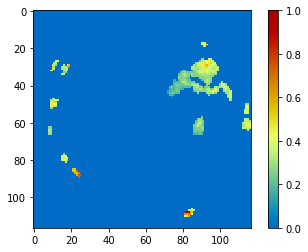

In [7]:
plt.imshow(first_greyscale_field, cmap='pyart_HomeyerRainbow')
plt.colorbar()

In [4]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(117,117), n_channels=1,
                 n_classes=10, shuffle=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, 3, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            for j in range(3):
                X[i, j, :, :, 0] = get_greyscale_field(radar_list[ID+j])
                # Store class
            the_array = get_greyscale_field(radar_list[ID+3])
            y[i, :, :, 0] = the_array
        return X, y

In [100]:
x, y = training_data[0]

1494.3008


KeyboardInterrupt: 

1533.3872
1515.1788


In [103]:
y[8,:,:,0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

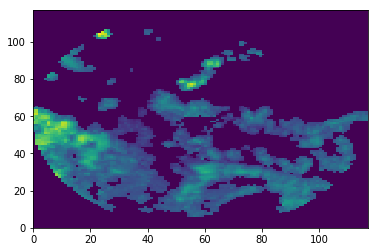

In [104]:
plt.pcolormesh(y[12,:,:,0])

In [8]:
plt.pcolormesh(x[0][0,1,:,:,0])

NameError: name 'x' is not defined

In [5]:
num_steps = 3
conv_window = 3
batch_size = 1
train_data_len = round(0.8*len(radar_list))
labels = {}
# Create labels for each member of radar dataset
for i in range(len(radar_list)):
    label_key = "id-" + str(i)
    labels[label_key] = i
    
training_data = DataGenerator([int(x) for x in range(0, train_data_len)], labels,
                              batch_size=30, n_classes=1)
validation_data = DataGenerator([int(x) for x in range(train_data_len, len(radar_list))], labels,
                                batch_size=30, n_classes=1)

In [38]:
hidden_size = 5
use_dropout=True
the_array = first_greyscale_field
new_shape = (num_steps, the_array.shape[0], the_array.shape[1], 1)
new_shape_conv10 = (num_steps, the_array.shape[0]-conv_window, the_array.shape[1]-conv_window, 1)
model = Sequential()

model.add(ConvLSTM2D(filters=1, kernel_size=(9, 9),
                     input_shape=new_shape, data_format='channels_last', return_sequences=True,
                     padding='valid', activation='relu'))
model.add(ConvLSTM2D(filters=1, kernel_size=(conv_window, conv_window),
                     input_shape=new_shape, data_format='channels_last', return_sequences=False,
                     padding='valid', activation='relu'))

model.add(ZeroPadding2D(5))
#odel.add(ConvLSTM2D(1, 10, input_shape=new_shape_conv10, data_format='channels_last', return_sequences=True))
#if use_dropout:
#    model.add(Dropout(0.5))
model.compile(loss='mean_squared_error', optimizer='adam')

INFO (theano.gof.compilelock): Refreshing lock /blues/gpfs/home/rjackson/.theano/compiledir_Linux-3.10-el7.x86_64-x86_64-with-centos-7.6.1810-Core-x86_64-3.7.3-64/lock_dir/lock


In [10]:
data_path = '/home/rjackson/deep_learning_fun'
checkpointer = ModelCheckpoint(filepath=data_path + '/2-layer-model-{epoch:02d}.hdf5', verbose=1)

In [ ]:
num_epochs = 30
model.fit_generator(training_data, None, epochs=10, callbacks=[checkpointer])

Epoch 1/10
118/118 [==============================] - 4516s 38s/step - loss: 0.0144

Epoch 00001: saving model to /home/rjackson/deep_learning_fun/2-layer-model-01.hdf5
Epoch 2/10
118/118 [==============================] - 4543s 39s/step - loss: 0.0134

Epoch 00002: saving model to /home/rjackson/deep_learning_fun/2-layer-model-02.hdf5
Epoch 3/10
 97/118 [=======================>......] - ETA: 13:22 - loss: 0.0125

In [10]:
from keras.models import load_model
model = load_model('/home/rjackson/deep_learning_fun/2-layer-model-03.hdf5')

In [11]:
y_model = model.predict_generator(validation_data, steps=30)

In [12]:
y_model.shape

(900, 117, 117, 1)

In [13]:
output_png_path_model = '/home/rjackson/various_notebooks/deep_learning_quicklooks/model'
for i in range(0, y_model.shape[0]):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    im = ax.imshow(y_model[i,:,:,0], vmin=0, vmax=1, cmap='pyart_HomeyerRainbow')
    ax.set_title('Time step ' + str(i))
    ax.set_xlabel('X [km]')
    ax.set_ylabel('Y [km]')
    plt.colorbar(im, label='Normalized reflectivity')
    fig.savefig(output_png_path_model + '/' + str(i) + '.png')
    plt.close(fig)

In [15]:
output_png_path_observations = '/home/rjackson/various_notebooks/deep_learning_quicklooks/observations'
for j in range(30):
    y_validation = training_data[j]
    my_data = y_validation[1]
    for i in range(0, my_data.shape[0]):
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        im = ax.imshow(my_data[i,:,:,0], vmin=0, vmax=1, cmap='pyart_HomeyerRainbow')
        ax.set_title('Time step ' + str(j*30 + i))
        plt.colorbar(im, label='Normalized reflectivity')
        fig.savefig(output_png_path_observations + '/' + str(j*30 + i) + '.png')
        plt.close(fig)

IndexError: index 3 is out of bounds for axis 0 with size 2

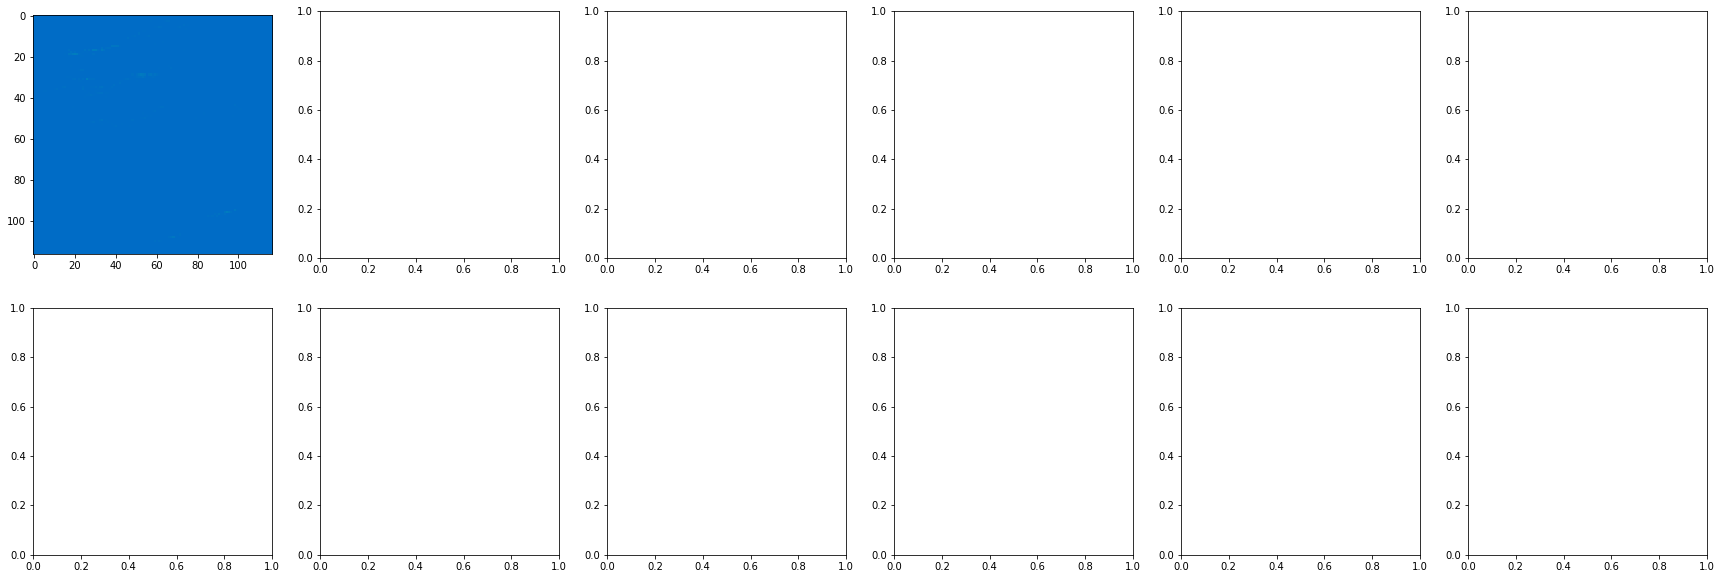

In [30]:
fig, ax = plt.subplots(2,6, figsize=(30,10))
imin = 20
imax = 30
for i in range(imin, imax):
    the_plot = ax[(i-imin)//6,(i-imin)%6].imshow(y_model[i,:,:,0], vmin=0, vmax=1, cmap='pyart_HomeyerRainbow')
    plt.colorbar(the_plot, ax=ax[i//6,i%6], label='Reflectivity [% of maximum]')
    plt.title('Predicted reflectivity (normalized)')

In [ ]:
fig, ax = plt.subplots(2,6, figsize=(30,10))
my_data = y_validation[1]
imin = 20
imax = 30
for i in range(imin, imax):
    my_img = np.squeeze(my_data[i])
    the_plot = ax[(i-imin)//6,(i-imin)%6].imshow(my_img/my_img.max(), vmin=0, vmax=1, cmap='pyart_HomeyerRainbow')
    plt.colorbar(the_plot, ax=ax[(i-imin)//6,(i-imin)%6], label='Reflectivity [% of maximum]')

In [ ]:
plt.pcolormesh(y_model[3, :,:,0], vmin=0, vmax=0.2, cmap='pyart_HomeyerRainbow')

In [ ]:
y_validation = validation_data[1]

In [ ]:
plt.pcolormesh(np.squeeze(y[1]))

In [51]:
y_validation[1][1].shape

(1, 117, 117, 1)

In [18]:
my_img

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])